In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot2, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT
# from Welch_func import Welch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


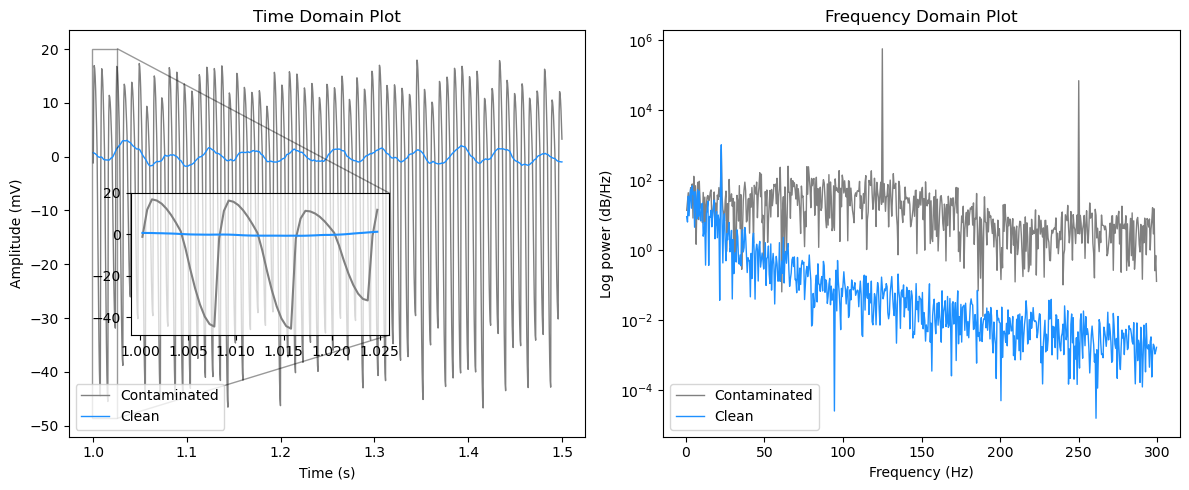

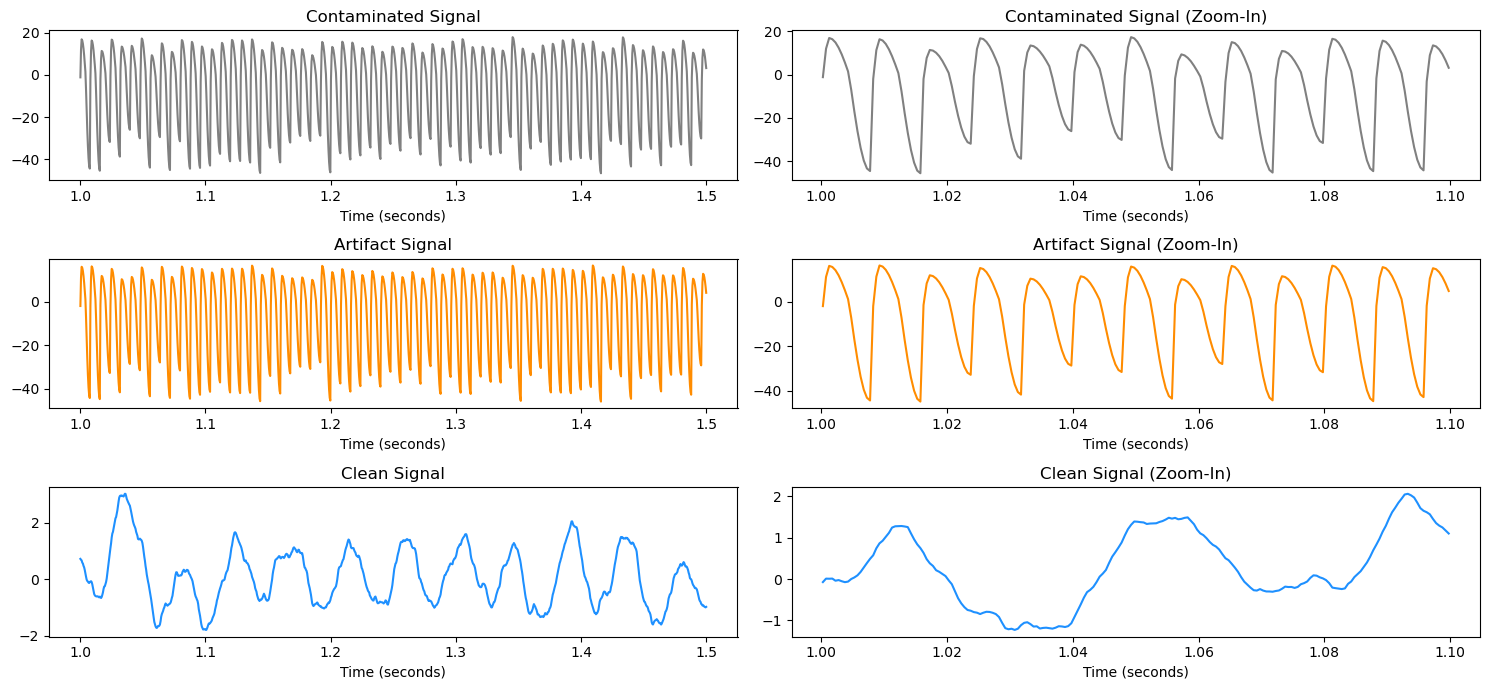

In [2]:
# 데이터 load & plot
datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)
y_train = y_train.reshape(y_train.shape[0], 1, 4000) # B x 1 x T
y_test = y_test.reshape(y_test.shape[0], 1, 4000)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 1, 4000), y_train shape: (800, 1, 4000)
unsqueezed X_test shape: (200, 1, 4000), y_test shape: (200, 1, 4000)


In [5]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [6]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x T
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 모델 파라미터 저장
torch.save(model.state_dict(), '../model_saved/experiment.pth')

Epoch 5/200, Loss: 0.0024065817706286907
Epoch 10/200, Loss: 0.0018021119758486748
Epoch 15/200, Loss: 0.0008456232026219368
Epoch 20/200, Loss: 0.00020889422739855945
Epoch 25/200, Loss: 0.00014025218843016773
Epoch 30/200, Loss: 0.00012398697435855865
Epoch 35/200, Loss: 0.0001902007352327928
Epoch 40/200, Loss: 0.00012294607586227357
Epoch 45/200, Loss: 0.00012116177822463214
Epoch 50/200, Loss: 0.00012081224849680439
Epoch 55/200, Loss: 6.907877104822546e-05
Epoch 60/200, Loss: 0.00025529510458000004
Epoch 65/200, Loss: 6.261113594518974e-05
Epoch 70/200, Loss: 5.7607270719017833e-05
Epoch 75/200, Loss: 6.559109897352755e-05
Epoch 80/200, Loss: 8.198228169931099e-05
Epoch 85/200, Loss: 0.00011720764450728893
Epoch 90/200, Loss: 5.183997200219892e-05
Epoch 95/200, Loss: 6.624895468121395e-05
Epoch 100/200, Loss: 6.341495463857427e-05
Epoch 105/200, Loss: 9.28037625271827e-05
Epoch 110/200, Loss: 5.0585651479195803e-05
Epoch 115/200, Loss: 0.00011084492871304974
Epoch 120/200, Loss: 

In [7]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 5.094260995974764e-05


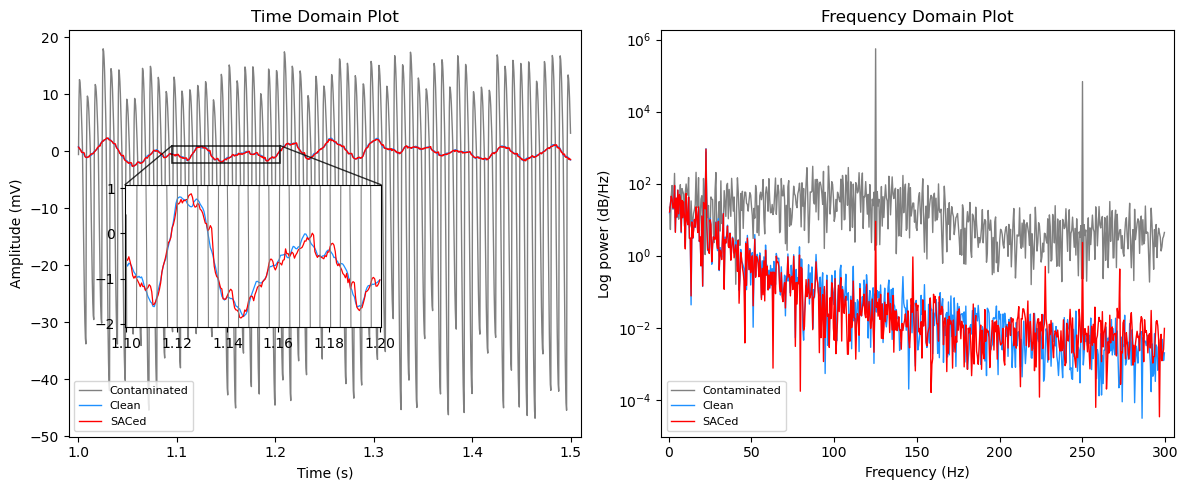

< MSE >
Time Domain MSE: 0.01762391689869097 ± 0.0013847800379997177
Frequency Domain MSE: 0.9933929580284747 ± 0.3378225710129738


In [8]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) 

# result_data = [Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled]
# save_path = '../../../result/output_data/'
# np.save(save_path + "model_output" + ".npy", result_data)

Contaminated_data.shape: (2000, 4000)
Clean_data.shape: (2000, 4000)


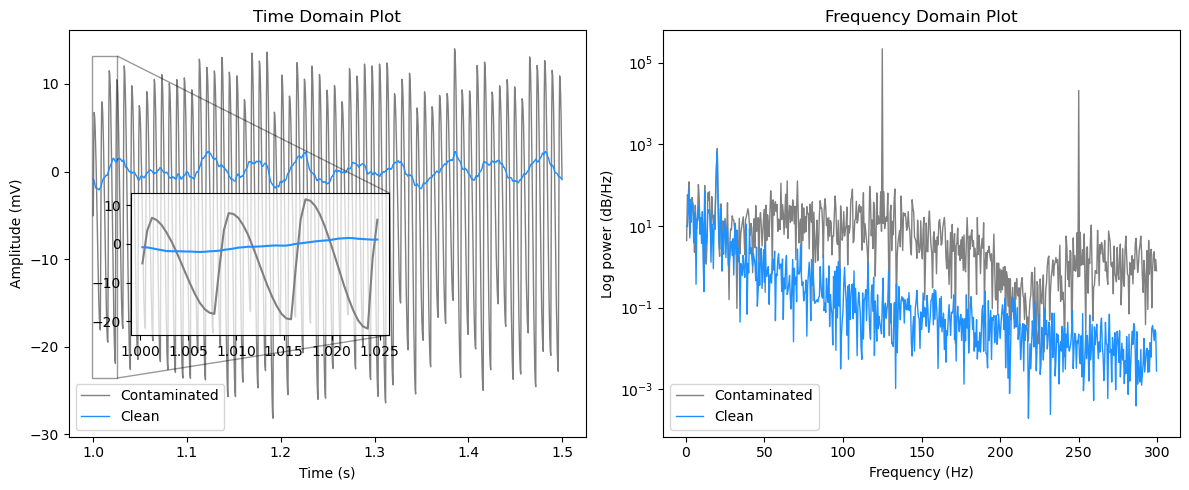

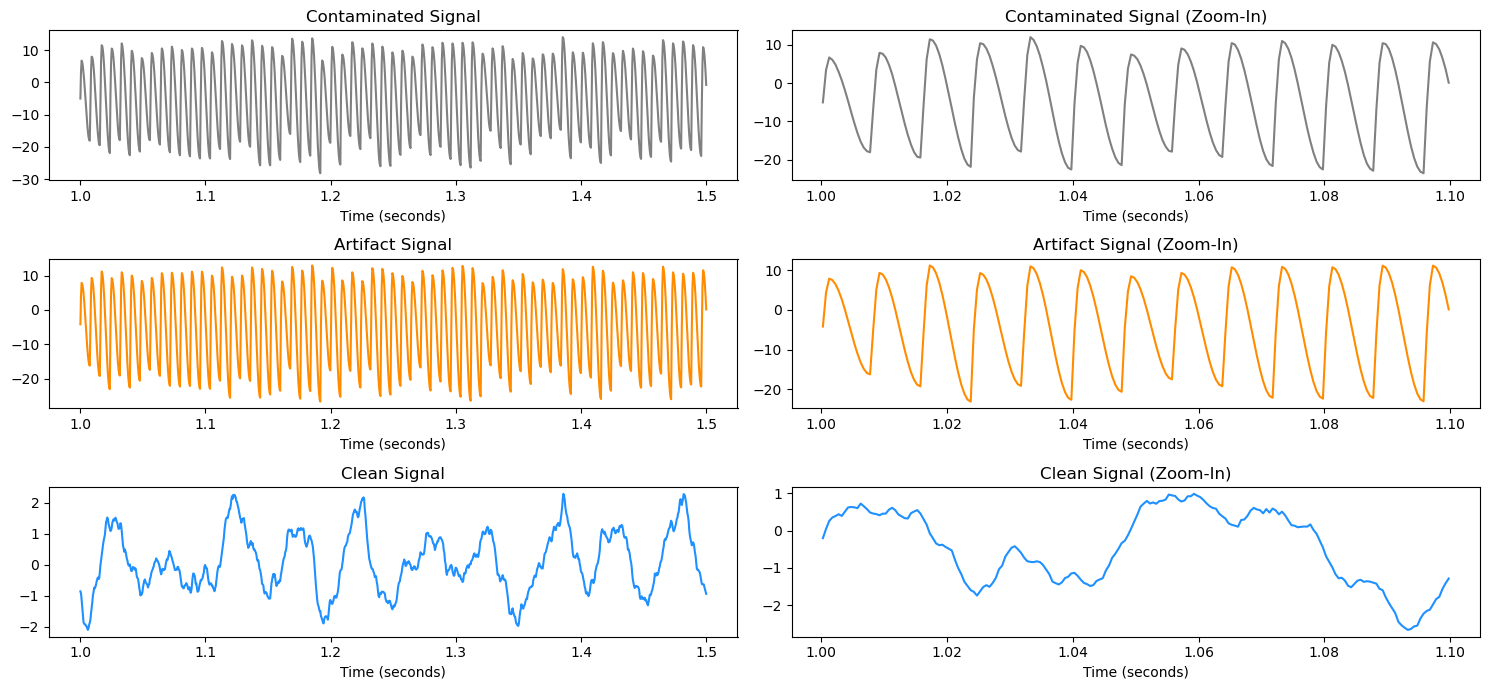

X: (2000, 4000)
y: (2000, 4000)


C:\Users\stell\AppData\Local\Temp\ipykernel_20080\1695127608.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model.load_state_dict(torch.load('../model_saved/exper

In [10]:
### Evaluation

# 데이터 load & plot
datapath="../../../data/evaluation_data/"

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

# Data Standard Scaling
X, Y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X_test = X.reshape(X.shape[0], 1, 4000)
Y_test = Y.reshape(Y.shape[0], 1, 4000)


eval_test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.float32))
eval_test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)


eval_model = CNN().to(device)
eval_model.load_state_dict(torch.load('../model_saved/experiment.pth'))
criterion = nn.MSELoss()

In [11]:
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

eval_model.eval()
with torch.no_grad():
    for batch in eval_test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = eval_model(x) # y_pred : B x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 5.094260995974764e-05


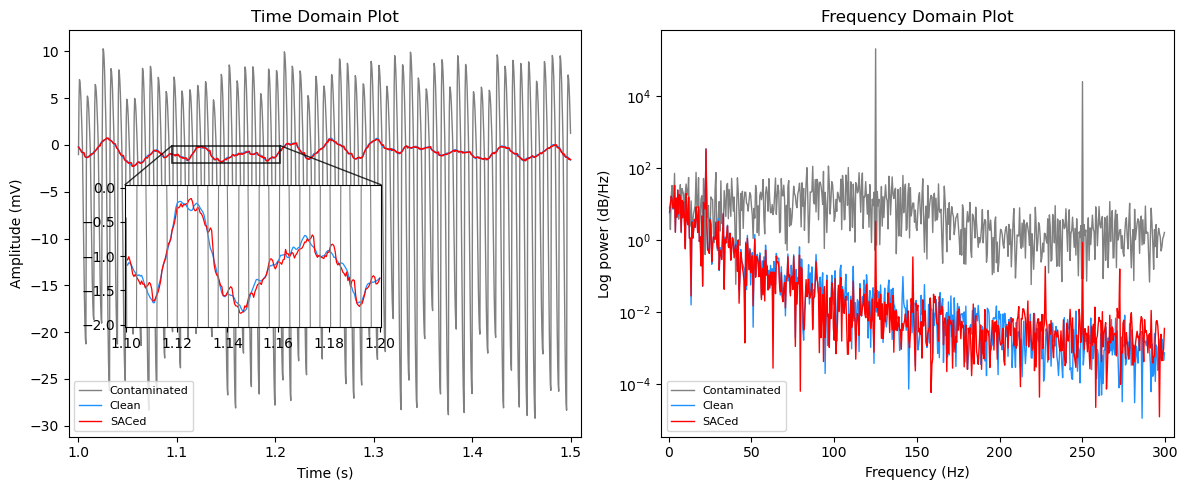

< MSE >
Time Domain MSE: 0.006528330177013275 ± 0.0005129564195386453
Frequency Domain MSE: 0.3075342268931639 ± 0.17692663311952608


In [12]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) 

In [ ]:
evaluation_fpath = '../../../data/evaluation_data/'
Contaminated_evaluation = np.load(evaluation_fpath + 'contaminated_by_realistic.npy')
Clean_evaluation = np.load(evaluation_fpath + 'clean_by_realistic.npy')

In [ ]:
fs =2000
freqs,_,_,psd_Contaminated = FFT(Contaminated_inv_scaled, fs, single_sided=True)
_,_,_,psd_SACed = FFT(SACed_inv_scaled, fs, single_sided=True)
_,_,_,psd_Clean = FFT(Clean_inv_scaled, fs, single_sided=True)

# 결과 출력
plt.figure(figsize=(10, 6))


plt.plot(freqs, np.log10(psd_Contaminated[0]))
plt.plot(freqs, np.log10(psd_SACed[0]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend(['Original', 'Notched'])

plt.tight_layout()
plt.show()

In [ ]:
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

In [ ]:
# 결과 Plot
Result_Plot2(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

In [ ]:
Result_Plot_paper(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음